In [1]:
!pip install numba numexpr seaborn Cython

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
!pip install cupy-cuda100 #the cuda100 corresponds to the release 10.0 above. It was 10.1 we would use cuda101

In [4]:
import sys
import platform
import os
import random as rnd
from math import sqrt, sin, cos, radians
import numpy as np
import pandas as pd
from numba import jit
import numba
import numexpr as ne
import matplotlib.pyplot as plt
import seaborn
import cupy as cp

In [5]:
%matplotlib inline 
seaborn.set()

# Software Versions and Machine Hardware

In [6]:
print("Python: {}\nNumpy: {}\nPandas: {}\nNumba: {}\nNumexpr: {}\n{}".format(sys.version,
                                                                             np.__version__,
                                                                             pd.__version__,
                                                                             numba.__version__,
                                                                             ne.__version__,
                                                                             ne.get_vml_version()))
print("Processor: {}\n# of Cores: {}\nMachine: {}\nArchitecture: {}".format(platform.processor(),
                                                                            os.cpu_count(),
                                                                            platform.machine(),
                                                                            platform.architecture()))
#Note:
#Intel64 Family 6 Model 78 Stepping 3 = Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz

Python: 3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
Numpy: 1.19.5
Pandas: 1.1.5
Numba: 0.52.0
Numexpr: 2.7.2
None
Processor: x86_64
# of Cores: 4
Machine: x86_64
Architecture: ('64bit', '')


# Define Sample Data

List of tuples where list is made of tuples and each tuple has 4 values defining the point.

In [7]:
points_10k = []
points_1m = []
size = (10000, 1000000)
points_obj = (points_10k, points_1m)
for s, var in ((size[0], points_obj[0]), (size[1], points_obj[1])):
    for i in range(s):
        var.append((rnd.uniform(-85,85),
                       rnd.uniform(-175,175),
                       rnd.uniform(-50,12000), 
                       rnd.uniform(-50,50)))
    print ('{} of {} containing {}, length: {}.'.format(type(var),type(var[0]),type(var[0][0]),len(var)))

<class 'list'> of <class 'tuple'> containing <class 'float'>, length: 10000.
<class 'list'> of <class 'tuple'> containing <class 'float'>, length: 1000000.


Numpy arrays...

In [8]:
#instead of using np.random.uniform to define these arrays, converting the points list
#so the same values are used for all methods
points_10k_np = np.empty([size[0],4], dtype=np.double)
points_1m_np = np.empty([size[1],4], dtype=np.double)
points_obj_np = (points_10k_np, points_1m_np)

for i, var in enumerate(points_obj_np):
    for i, point in enumerate(points_obj[i]):
        var[i,:] = [point[0], point[1], point[2], point[3]]
    print ('{}, shape: {}.'.format(type(var),var.shape))

<class 'numpy.ndarray'>, shape: (10000, 4).
<class 'numpy.ndarray'>, shape: (1000000, 4).


Pandas DataFrame of the points.

In [9]:
points_10k_df = pd.DataFrame(points_10k, columns=['Lat','Long','Alt','Geoid'])
points_1m_df = pd.DataFrame(points_1m, columns=['Lat','Long','Alt','Geoid'])
points_obj_df = (points_10k_df, points_1m_df)
for var in points_obj_df:
    print ('{} containing {}, length: {}.'.format(type(var),
                                                  type(var.iloc[0,0]),
                                                  len(var)))

<class 'pandas.core.frame.DataFrame'> containing <class 'numpy.float64'>, length: 10000.
<class 'pandas.core.frame.DataFrame'> containing <class 'numpy.float64'>, length: 1000000.


In [10]:
timing_results = pd.DataFrame()

def timing_results_filler (r, return_size=3):
    #TODO: remove return_size
    returner = {}
    #Loops,Repeat,Best
    returner['Loops'] = r.loops
    returner['Repeat'] = r.repeat
    returner['Time (sec)'] = r.best
    return returner

# Constants

In [11]:
a = 6378137  # Semi-major axis 
b = 6356752.3142  # Semi-minor axis
f = (a - b) / a  # flattening
e = 0.081819191 # eccentricity
ee = e*e
LOOPS = 50
REPEAT = 5

# Native Python Lists

In [12]:
def LLAtoXYZ_raw (latitude, longitude, altitude, geoidSepIn = 0):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = radians(latitude)
    longitude_rad = radians(longitude)
    height = altitude - geoidSepIn
    cos_lat = cos(latitude_rad)
     
    r = a / sqrt(1 - ee * sin(latitude_rad) * sin(latitude_rad))
    x = (r + height) * cos_lat * cos(longitude_rad)
    y = (r + height) * cos_lat * sin(longitude_rad)
    z = ((1 - ee) * r + height) * sin(latitude_rad)
        
    return x,y,z
LLAtoXYZ_raw(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

(-2856867.422762463, -4132876.8004144537, -3916387.577890978)

In [13]:
test_config_name = 'Native Python'
for points in points_obj:
    results = []
    r = %timeit -o for p in points: results.append(LLAtoXYZ_raw(p[0],p[1],p[2],p[3]))
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = len(points)
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

13.8 ms ± 542 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.36 s ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Numpy Arrays

In [14]:
#import numpy functions directly
from numpy import sqrt, sin, cos, radians

In [15]:
def LLAtoXYZ_numpy (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = radians(latitude)
    longitude_rad = radians(longitude)
    height = altitude - geoidSepIn
    cos_lat = cos(latitude_rad)
     
    r = a / sqrt(1 - ee * sin(latitude_rad) * sin(latitude_rad))
    x = (r + height) * cos_lat * cos(longitude_rad)
    y = (r + height) * cos_lat * sin(longitude_rad)
    z = ((1 - ee) * r + height) * sin(latitude_rad)
    
    if return_array:
        return np.array([x,y,z])
    else:
        return x,y,z
    
LLAtoXYZ_numpy(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

(-2856867.422762463, -4132876.8004144537, -3916387.577890978)

In [16]:
test_config_name = 'Numpy (Native)'
for points in points_obj_np:
    r = %timeit -n 50 -r 5 -o results = LLAtoXYZ_numpy(points[:,0],points[:,1],points[:,2],points[:,3],True)
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = points.shape[0]
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

2 ms ± 20.4 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
211 ms ± 1.14 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


# Cupy Arrays

In [17]:
#import numpy functions directly
import cupy as cp

In [18]:
def LLAtoXYZ_cupy (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = cp.radians(latitude)
    longitude_rad = cp.radians(longitude)
    height = altitude - geoidSepIn
    cos_lat = cp.cos(latitude_rad)
     
    r = a / cp.sqrt(1 - ee * cp.sin(latitude_rad) * cp.sin(latitude_rad))
    x = (r + height) * cos_lat * cp.cos(longitude_rad)
    y = (r + height) * cos_lat * cp.sin(longitude_rad)
    z = ((1 - ee) * r + height) * cp.sin(latitude_rad)
    
    if return_array:
        return cp.array([x,y,z])
    else:
        return x,y,z
    
LLAtoXYZ_cupy(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

(array(-2856867.42276246), array(-4132876.80041445), array(-3916387.57789098))

In [25]:
points_10k_cp = cp.array(points_10k_np)
points_1m_cp = cp.array(points_1m_np)
points_obj_cp = (points_10k_cp, points_1m_cp)

In [26]:
test_config_name = 'Cupy (Native)'
for points in points_obj_cp:
    r = %timeit -n 50 -r 5 -o results = LLAtoXYZ_cupy(points[:,0],points[:,1],points[:,2],points[:,3],True)
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = points.shape[0]
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

456 µs ± 84.4 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
The slowest run took 4.27 times longer than the fastest. This could mean that an intermediate result is being cached.
3.27 ms ± 1.16 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


# Pandas (Serialized)
added to show how slow pandas can be if not vectorized

In [27]:
# r = %timeit -n 5 -r 5 -o points_df['X'],points_df['Y'],points_df['Z'] = \ 
#                           zip(*points_df.apply(lambda row: LLAtoXYZ_raw(row[0], \
#                                                                         row[1], \
#                                                                         row[2], \
#                                                                         row[3]), \
#                                                                         axis=1))
# timing_results.loc['Pandas (Serialized)'] = timing_results_filler(r)

# Pandas (Vectorized)

In [28]:
test_config_name = 'Pandas (Native)'
for points_df in points_obj_df:
    r = %timeit -n 50 -r 5 -o points_df['X'],points_df['Y'],points_df['Z'] = LLAtoXYZ_numpy(points_df['Lat'], \
                                                                                            points_df['Long'], \
                                                                                            points_df['Alt'], \
                                                                                            points_df['Geoid'],False)
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = len(points_df)
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

6.19 ms ± 146 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
235 ms ± 3.33 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


# Numpy (Vectorize)

In [29]:
np_vec = np.vectorize(LLAtoXYZ_numpy)

In [30]:
test_config_name = 'Numpy (Vectorize)'
for points_df in points_obj_df:
    r = %timeit -n 1 -r 1 -o points_df['X'],points_df['Y'],points_df['Z'] = np_vec(points_df['Lat'], \
                                                                                            points_df['Long'], \
                                                                                            points_df['Alt'], \
                                                                                            points_df['Geoid'],False)
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = len(points_df)
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

146 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
14.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Numba

In [31]:
@jit
def LLAtoXYZ_jit (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = radians(latitude)
    longitude_rad = radians(longitude)
    height = altitude - geoidSepIn
    cos_lat = cos(latitude_rad)
     
    r = a / np.sqrt(1 - ee * sin(latitude_rad) * sin(latitude_rad))
    x = (r + height) * cos_lat * cos(longitude_rad)
    y = (r + height) * cos_lat * sin(longitude_rad)
    z = ((1 - ee) * r + height) * sin(latitude_rad)
    
    if return_array:
        return np.array([x,y,z])
    else:
        return x,y,z
    
LLAtoXYZ_jit(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

<ipython-input-31-07a83d46d1da>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "LLAtoXYZ_jit" failed type inference due to: Can't unify return type from the following types: UniTuple(float64 x 3), array(float64, 1d, C)
Return of: IR name '$152.5', type 'UniTuple(float64 x 3)', location: 
File "<ipython-input-31-07a83d46d1da>", line 21:
def LLAtoXYZ_jit (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    <source elided>
    else:
        return x,y,z
        ^
Return of: IR name '$136.8', type 'array(float64, 1d, C)', location: 
File "<ipython-input-31-07a83d46d1da>", line 19:
def LLAtoXYZ_jit (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    <source elided>
    if return_array:
        return np.array([x,y,z])
        ^
  @jit
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "LLAtoXYZ_jit" was compiled in o

(-2856867.422762463, -4132876.8004144537, -3916387.577890978)

In [32]:
test_config_name = 'Numba (with Numpy Arrays)'
for points in points_obj_np:
    r = %timeit -n 50 -r 5 -o results = LLAtoXYZ_jit(points[:,0],points[:,1],points[:,2],points[:,3],True)
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = points.shape[0]
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

<ipython-input-31-07a83d46d1da>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "LLAtoXYZ_jit" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(list(array(float64, 1d, C))<iv=None>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'array': File: numba/core/typing/npydecl.py: Line 485.
    With argument(s): '(list(array(float64, 1d, C))<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: array(float64, 1d, C) not allowed in a homogeneous sequence
  raised from /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numba/core/typing/npydecl.py:453

During: resolving callee type: Function(<built-in function array>)
During: typing of call at <ipython-input-31-07a83d46d1da> (19)


File "<ipython-input-31-07a83d46d1da>", line 19:
def LLAtoXYZ_jit (latitude, lo

The slowest run took 5.23 times longer than the fastest. This could mean that an intermediate result is being cached.
3.73 ms ± 3.42 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)
227 ms ± 1.12 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


In [33]:
test_config_name = 'Numba (with Pandas)'
for points_df in points_obj_df:
    r = %timeit -n 50 -r 5 -o points_df['X'],points_df['Y'],points_df['Z'] = LLAtoXYZ_jit(points_df['Lat'], \
                                                                                          points_df['Long'], \
                                                                                          points_df['Alt'], \
                                                                                          points_df['Geoid'],False)
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = len(points_df)
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

<ipython-input-31-07a83d46d1da>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "LLAtoXYZ_jit" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-31-07a83d46d1da> (8)

File "<ipython-input-31-07a83d46d1da>", line 8:
def LLAtoXYZ_jit (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    <source elided>
    
    latitude_rad = radians(latitude)
    ^

  @jit
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "LLAtoXYZ_jit" was compiled in object mode without forceobj=True.

File "<ipython-input-31-07a83d46d1da>", line 2:
@jit
def LLAtoXYZ_jit (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
^

  state.func_ir.loc))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numba/core/object_mode_passes.py:162: NumbaDeprecationWarning: 
Fall-back from the nopyth

7.57 ms ± 2.5 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)
230 ms ± 4.4 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


# Numexpr

In [34]:
def LLAtoXYZ_ne (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = radians(latitude)
    longitude_rad = radians(longitude)
    height = altitude - geoidSepIn
     
    r = ne.evaluate("a / sqrt(1 - ee * sin(latitude_rad)**2)")
    x = ne.evaluate("(r + height) * cos(latitude_rad) * cos(longitude_rad)")
    y = ne.evaluate("(r + height) * cos(latitude_rad) * sin(longitude_rad)")
    z = ne.evaluate("((1 - ee) * r + height) * sin(latitude_rad)")
    
    if return_array:
        return np.array([x,y,z])
    else:
        return x,y,z
    
LLAtoXYZ_ne(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

(array(-2856867.42276246), array(-4132876.80041445), array(-3916387.57789098))

In [35]:
test_config_name = 'Numexpr (with Numpy Arrays)'
for points in points_obj_np:
    r = %timeit -n 50 -r 5 -o results = LLAtoXYZ_ne(points[:,0],points[:,0],points[:,0],points[:,0],True)
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = points.shape[0]
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

1.32 ms ± 20 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
85.9 ms ± 901 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)


In [36]:
test_config_name = 'Numexpr (with Pandas)'
for points_df in points_obj_df:
    r = %timeit -n 50 -r 5 -o points_df['X'],points_df['Y'],points_df['Z'] = LLAtoXYZ_ne(points_df['Lat'], \
                                                                                         points_df['Long'], \
                                                                                         points_df['Alt'], \
                                                                                         points_df['Geoid'],False)
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = len(points_df)
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

2.43 ms ± 18.9 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
89 ms ± 360 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)


# Cython

In [37]:
%load_ext Cython

In [38]:
%%cython
from cython cimport boundscheck, wraparound
from libc.math cimport sin, cos, sqrt, M_PI
import numpy as np
cimport numpy as cnp

cdef double a = 6378137       # Semi-major axis 
cdef double b = 6356752.3142  # Semi-minor axis
cdef double f = (a - b) / a   # flattening
cdef double e = 0.081819191
cdef double ecc = e*e
cdef double radians = M_PI/180.0

@boundscheck(False)
@wraparound(False)
def LLAtoXYZ_cy(double[:] latitude, 
                double[:] longitude, 
                double[:] altitude, 
                double[:] geoidSepIn):
    cdef int i
    cdef int l = len(latitude)
    
    cdef double[:] x = np.empty(l, dtype=np.double)
    cdef double[:] y = np.empty(l, dtype=np.double)
    cdef double[:] z = np.empty(l, dtype=np.double)
    
    cdef double latitude_rad
    cdef double longitude_rad
    cdef double height
    cdef double s_lat
    cdef double c_lat
    cdef double r
    
    for i in range(l):
        latitude_rad = radians*latitude[i]
        longitude_rad = radians*longitude[i]
        height = altitude[i] - geoidSepIn[i]
        s_lat  = sin(latitude_rad)
        c_lat  = cos(latitude_rad)
         
        r = a / sqrt(1 - ecc * s_lat * s_lat)
        x[i] = (r + height) * c_lat * cos(longitude_rad)
        y[i] = (r + height) * c_lat * sin(longitude_rad)
        z[i] = ((1-ecc) * r + height) * s_lat
        
    return x,y,z

In [39]:
results_c = LLAtoXYZ_cy(np.array([-38.123456], dtype=np.double),
                     np.array([-124.65432], dtype=np.double),
                     np.array([230], dtype=np.double),
                       np.array([-20], dtype=np.double))
print (results_c[0][0], results_c[1][0], results_c[2][0])
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978)

-2856867.422762463 -4132876.8004144537 -3916387.577890978


In [40]:
test_config_name = 'Cython (with Numpy Arrays)'
for points in points_obj_np:
    r = %timeit -n 50 -r 5 -o results=LLAtoXYZ_cy(points[:,0],points[:,1],points[:,2],points[:,3])
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = points.shape[0]
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

1.2 ms ± 32.7 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
118 ms ± 102 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)


# Cython (parallel)

In [41]:
%%cython
from cython cimport boundscheck, wraparound
from cython.parallel cimport prange
from libc.math cimport sin, cos, sqrt, M_PI
import numpy as np
cimport numpy as cnp

cdef double a = 6378137       # Semi-major axis 
cdef double b = 6356752.3142  # Semi-minor axis
cdef double f = (a - b) / a   # flattening
cdef double e = 0.081819191
cdef double ecc = e*e
cdef double radians = M_PI/180.0

@boundscheck(False)
@wraparound(False)
def LLAtoXYZ_cy_par(double[:] latitude, 
                double[:] longitude, 
                double[:] altitude, 
                double[:] geoidSepIn):
    cdef int i
    cdef int l = len(latitude)
    
    cdef double[:] x = np.empty(l, dtype=np.double)
    cdef double[:] y = np.empty(l, dtype=np.double)
    cdef double[:] z = np.empty(l, dtype=np.double)
    
    cdef double latitude_rad
    cdef double longitude_rad
    cdef double height
    cdef double s_lat
    cdef double c_lat
    cdef double r
    
    for i in prange(l, nogil=True):
        latitude_rad = radians*latitude[i]
        longitude_rad = radians*longitude[i]
        height = altitude[i] - geoidSepIn[i]
        s_lat  = sin(latitude_rad)
        c_lat  = cos(latitude_rad)
         
        r = a / sqrt(1 - ecc * s_lat * s_lat)
        x[i] = (r + height) * c_lat * cos(longitude_rad)
        y[i] = (r + height) * c_lat * sin(longitude_rad)
        z[i] = ((1-ecc) * r + height) * s_lat
        
    return x,y,z

In [42]:
results_c = LLAtoXYZ_cy_par(np.array([-38.123456], dtype=np.double),
                     np.array([-124.65432], dtype=np.double),
                     np.array([230], dtype=np.double),
                       np.array([-20], dtype=np.double))
print (results_c[0][0], results_c[1][0], results_c[2][0])
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978)

-2856867.422762463 -4132876.8004144537 -3916387.577890978


In [43]:
test_config_name = 'Cython.Parallel (with Numpy Arrays)'
for points in points_obj_np:
    r = %timeit -n 50 -r 5 -o results=LLAtoXYZ_cy_par(points[:,0],points[:,1],points[:,2],points[:,3])
    row = timing_results_filler(r)
    row['Name'] = test_config_name
    row['Num of Points'] = points.shape[0]
    timing_results = timing_results.append(pd.Series(row),ignore_index=True)

1.2 ms ± 3.48 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
120 ms ± 69.4 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)


# Summary

In [44]:
def results_update(data):
    data = data.set_index('Name')
    data['Vs Native Python'] = data.loc['Native Python']['Time (sec)'] / data['Time (sec)']
    data['Time per Point (usec)'] = data['Time (sec)'] / data['Num of Points'] * 1000000
    return data

In [45]:
timing_results = timing_results.groupby('Num of Points').apply(results_update)

In [46]:
timing_results

Loops  Num of Points  \
Num of Points Name                                                        
10000.0       Native Python                        100.0        10000.0   
              Numpy (Native)                        50.0        10000.0   
              Cupy (Native)                         50.0        10000.0   
              Pandas (Native)                       50.0        10000.0   
              Numpy (Vectorize)                      1.0        10000.0   
              Numba (with Numpy Arrays)             50.0        10000.0   
              Numba (with Pandas)                   50.0        10000.0   
              Numexpr (with Numpy Arrays)           50.0        10000.0   
              Numexpr (with Pandas)                 50.0        10000.0   
              Cython (with Numpy Arrays)            50.0        10000.0   
              Cython.Parallel (with Numpy Arrays)   50.0        10000.0   
1000000.0     Native Python                          1.0      1000000.0   
              Numpy (Native)                        50.0      1000000.0   
              Cupy (Native)                         50.0      1000000.0   
              Pandas (Native)                       50.0      1000000.0   
              Numpy (Vectorize)                      1.0      1000000.0   
              Numba (with Numpy Arrays)             50.0      1000000.0   
              Numba (with Pandas)                   50.0      1000000.0   
              Numexpr (with Numpy Arrays)           50.0      1000000.0   
              Numexpr (with Pandas)                 50.0      1000000.0   
              Cython (with Numpy Arrays)            50.0      1000000.0   
              Cython.Parallel (with Numpy Arrays)   50.0      1000000.0   

                                                   Repeat  Time (sec)  \
Num of Points Name                                                      
10000.0       Native Python                           7.0    0.013445   
              Numpy (Native)                          5.0    0.001986   
              Cupy (Native)                           5.0    0.000401   
              Pandas (Native)                         5.0    0.006039   
              Numpy (Vectorize)                       1.0    0.146234   
              Numba (with Numpy Arrays)               5.0    0.002018   
              Numba (with Pandas)                     5.0    0.006309   
              Numexpr (with Numpy Arrays)             5.0    0.001303   
              Numexpr (with Pandas)                   5.0    0.002413   
              Cython (with Numpy Arrays)              5.0    0.001173   
              Cython.Parallel (with Numpy Arrays)     5.0    0.001196   
1000000.0     Native Python                           7.0    1.349125   
              Numpy (Native)                          5.0    0.208478   
              Cupy (Native)                           5.0    0.000966   
              Pandas (Native)                         5.0    0.232368   
              Numpy (Vectorize)                       1.0   14.580661   
              Numba (with Numpy Arrays)               5.0    0.225817   
              Numba (with Pandas)                     5.0    0.226945   
              Numexpr (with Numpy Arrays)             5.0    0.084840   
              Numexpr (with Pandas)                   5.0    0.088496   
              Cython (with Numpy Arrays)              5.0    0.117908   
              Cython.Parallel (with Numpy Arrays)     5.0    0.120311   

                                                   Vs Native Python  \
Num of Points Name                                                    
10000.0       Native Python                                1.000000   
              Numpy (Native)                               6.771266   
              Cupy (Native)                               33.493486   
              Pandas (Native)                              2.226478   
              Numpy (Vectorize)                            0.091945   


In [47]:
timing_results.to_csv('results.csv')

## Graphs

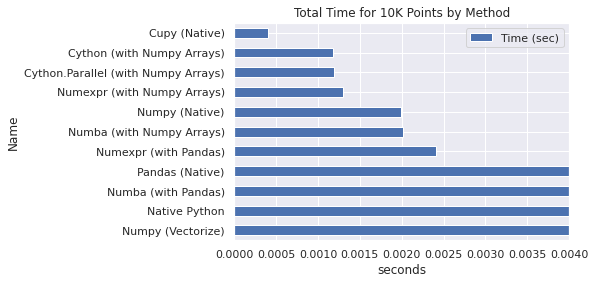

In [48]:
tenK_df = timing_results.where(timing_results['Num of Points'] == 10000).dropna().reset_index(0,drop=True)
tenK_df.sort_values('Time (sec)', inplace=True, ascending=False)
tenK_df_subset = tenK_df.reindex(columns=['Time (sec)'])
ax_10k_time = tenK_df_subset.plot(kind='barh')
ax_10k_time.set_yticklabels(list(tenK_df.index))
ax_10k_time.set_xbound(upper=.004)
ax_10k_time.set_xlabel('seconds')
ax_10k_time.set_title('Total Time for 10K Points by Method')
plt.savefig('time_10k.png')

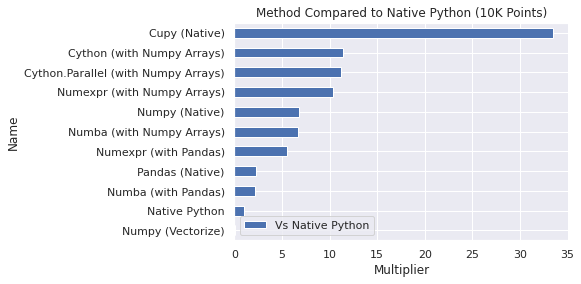

In [49]:
tenK_df.sort_values('Vs Native Python', inplace=True, ascending=True)
tenK_df_subset = tenK_df.reindex(columns=['Vs Native Python'])
ax_10k_vs = tenK_df_subset.plot(kind='barh')
ax_10k_vs.set_yticklabels(list(tenK_df.index))
ax_10k_vs.set_xlabel('Multiplier')
ax_10k_vs.set_title('Method Compared to Native Python (10K Points)')
plt.savefig('compare_10k.png')

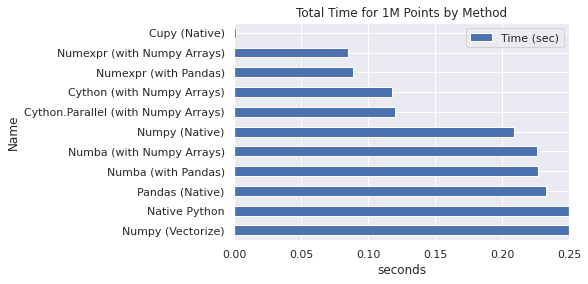

In [50]:
oneM_df = timing_results.where(timing_results['Num of Points'] == 1000000).dropna().reset_index(0,drop=True)
oneM_df.sort_values('Time (sec)', inplace=True, ascending=False)
oneM_df_subset = oneM_df.reindex(columns=['Time (sec)'])
ax_1M_time = oneM_df_subset.plot(kind='barh')
ax_1M_time.set_yticklabels(list(oneM_df.index))
ax_1M_time.set_xbound(upper=.25)
ax_1M_time.set_xlabel('seconds')
ax_1M_time.set_title('Total Time for 1M Points by Method')
plt.savefig('time_1M.png')

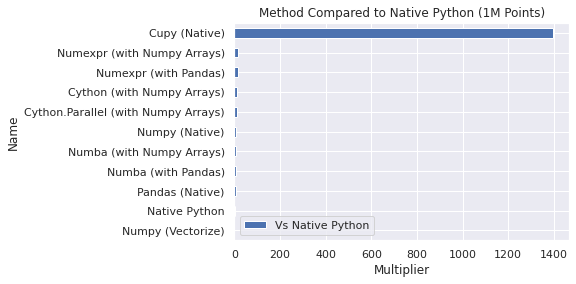

In [51]:
oneM_df.sort_values('Vs Native Python', inplace=True, ascending=True)
oneM_df_subset = oneM_df.reindex(columns=['Vs Native Python'])
ax_1M_vs = oneM_df_subset.plot(kind='barh')
ax_1M_vs.set_yticklabels(list(oneM_df.index))
ax_1M_vs.set_xlabel('Multiplier')
ax_1M_vs.set_title('Method Compared to Native Python (1M Points)')
plt.savefig('compare_1M.png')

In [ ]:
per_pt_df = pd.DataFrame()
per_pt_df['1M Points'] = timing_results['Time per Point (usec)'].where(timing_results['Num of Points'] == 1000000) \
                                                                            .dropna().reset_index(0,drop=True) * 1000
per_pt_df['10K Points'] = timing_results['Time per Point (usec)'].where(timing_results['Num of Points'] == 10000) \
                                                                            .dropna().reset_index(0,drop=True) * 1000
del per_pt_df.index.name
per_pt_df.sort_values('1M Points', inplace=True, ascending=False)
ax_per_pt = per_pt_df.plot(kind='barh', width = .8, figsize=(12,7))
ax_per_pt.set_xbound(upper=500)
ax_per_pt.set_title('Per Point Execution Time', fontsize=18)
ax_per_pt.set_xlabel('nanoseconds', fontsize=18)
ax_per_pt.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)
plt.legend(fontsize=14)
rects = ax_per_pt.patches
labels = per_pt_df.values.flatten('F')
ax_per_pt.tick_params(axis='y', labelsize=14)
for rect, label in zip(rects, labels):
    width = rect.get_width()
    height = rect.get_height()
    ax_per_pt.text(min(width - 20, 475), rect.get_y()+ height*3/4, int(label), color='white',fontsize=12, ha='left', va='top', weight='heavy')
plt.savefig('exec_time.png')

In [ ]:
vs_df = pd.DataFrame()
vs_df['1M Points'] = timing_results['Vs Native Python'].where(timing_results['Num of Points'] == 1000000) \
                                                                        .dropna().reset_index(0,drop=True)
vs_df['10K Points'] = timing_results['Vs Native Python'].where(timing_results['Num of Points'] == 10000) \
                                                                        .dropna().reset_index(0,drop=True)


del vs_df.index.name
vs_df.sort_values('1M Points', inplace=True, ascending=False)
ax_vs = vs_df.plot(kind='barh', width = .8, figsize=(12,7))
ax_vs.set_title('Method Compared to Native Python', fontsize=18)
ax_vs.set_xlabel('Improvement Over Native Python (as Multiplier)', fontsize=18)
ax_vs.yaxis.get_label_text()
ax_vs.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)
plt.legend(fontsize=14)
rects = ax_vs.patches
labels = vs_df.values.flatten('F')
labels = np.rint(labels)
ax_vs.tick_params(axis='y', labelsize=14)
for rect, label in zip(rects, labels):
    width = rect.get_width()
    height = rect.get_height()
    ax_vs.text(width+0.5, rect.get_y() + height/2, int(label), 
               fontsize=12, ha='left', va='center', weight='heavy')
plt.savefig('method_compare.png')